In [28]:
from matplotlib.colors import ListedColormap
from sklearn import datasets, metrics, tree
import numpy as np
colors = ListedColormap(['red', 'blue', 'yellow'])
light_colors = ListedColormap(['lightcoral', 'lightblue', 'lightyellow'])
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
df = pd.read_csv('https://drive.google.com/uc?authuser=0&id=1gV62b4ebqAZhZQytRn0tkaZeHSMhlequ&export=download', sep=';', engine='python')
df['balanceOrigErr'] = df['newbalanceOrig']+df['amount']-df['oldbalanceOrg']
df['balanceDestErr'] = df['oldbalanceDest']+df['amount']-df['newbalanceDest']
df=df.drop(['newbalanceOrig','oldbalanceOrg','oldbalanceDest','newbalanceDest'], axis=1)
X = df.drop(['isFraud','isFlaggedFraud'], axis=1)
y = df['isFraud']
print(df)
# Делим выборку на train и test, все метрики будем оценивать на тестовом датасете

train_data, test_data, train_label, test_label = train_test_split(X, y, test_size = 0.2, random_state=42)

         step  type     amount  ...  isFlaggedFraud  balanceOrigErr  balanceDestErr
0           1     3    9839.64  ...               0            0.00    9.839640e+03
1           1     3    1864.28  ...               0            0.00    1.864280e+03
2           1     4     181.00  ...               0            0.00    1.810000e+02
3           1     1     181.00  ...               0            0.00    2.136300e+04
4           1     3   11668.14  ...               0            0.00    1.166814e+04
5           1     3    7817.71  ...               0            0.00    7.817710e+03
6           1     3    7107.77  ...               0            0.00    7.107770e+03
7           1     3    7861.64  ...               0            0.00    7.861640e+03
8           1     3    4024.36  ...               0         1353.36    4.024360e+03
9           1     2    5337.77  ...               0            0.00    6.886980e+03
10          1     2    9644.94  ...               0         5179.94   -1.374

In [0]:
train_data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'nameDest', 'balanceOrigErr',
       'balanceDestErr'],
      dtype='object')

In [0]:
#Формируем веса для переменных
from sklearn.utils import compute_class_weight

w = compute_class_weight('balanced', np.unique(train_label), train_label)

weights = {
     np.unique(train_label)[0] : w[0], # class 0 with weight 0
     np.unique(train_label)[1] : w[1]  # class 1 with weight 1 
}

In [0]:
# Обучаем классификатор случайного леса
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=True, class_weight=weights,  criterion='gini', n_estimators = 100, random_state = 42)
rf = rf.fit(train_data, train_label);

In [0]:
estimator = rf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                max_depth = 3,
                feature_names = train_data.columns,
                #class_names = train_label.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

In [0]:
# Предсказания делаем по случайному лесу
predictions = rf.predict(test_data)
print(metrics.accuracy_score(test_label, predictions))
print(metrics.recall_score(test_label, predictions))
print(metrics.precision_score(test_label, predictions))
metrics.confusion_matrix(test_label, predictions)

0.9993801111031638
0.5131578947368421
0.8602941176470589


array([[209468,     19],
       [   111,    117]])

In [0]:
#Рассчитываем F-меру для случайного леса
print(2*(metrics.precision_score(test_label, predictions)*metrics.recall_score(test_label, predictions))/(metrics.precision_score(test_label, predictions)+metrics.recall_score(test_label, predictions)))

0.8704156479217603


In [0]:
#Функция по визуализации матрицы ошибок
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Исходные значения')
    plt.xlabel('Предсказаннные значения')

Confusion matrix, without normalization
[[209484      7]
 [    46    178]]


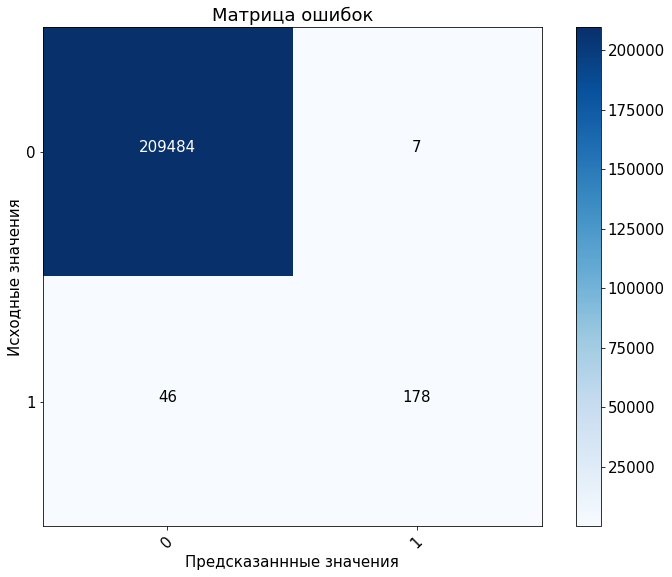

In [0]:
#Выводим на экран матрицу ошибок
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(test_label, rf.predict(test_data))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Матрица ошибок')
#plt.savefig("conf_matrix.png")
plt.show()

In [0]:
#Построение модели логистической регрессии
lr = LogisticRegression(random_state=42)
lr.fit(train_data, train_label)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Confusion matrix, without normalization
[[209422     69]
 [   172     52]]


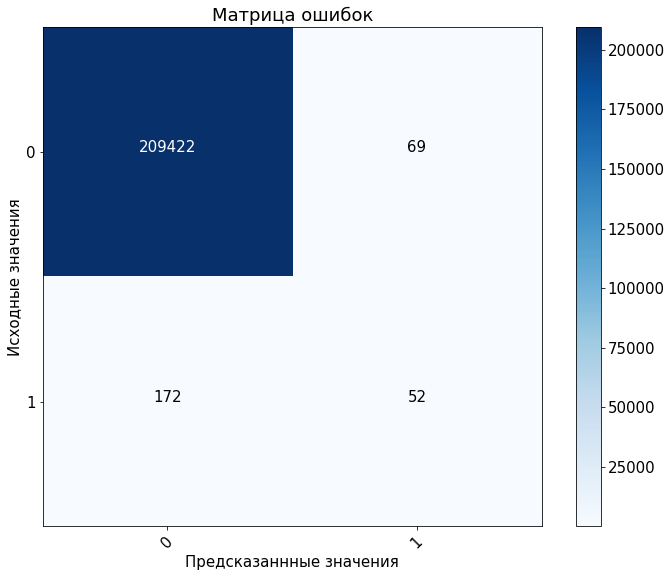

In [0]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(test_label, lr.predict(test_data))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Матрица ошибок')
#plt.savefig("conf_matrix.png")
plt.show()

In [4]:
import tensorflow
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout,LSTM,RNN
import keras
from keras import backend as K

Using TensorFlow backend.


In [0]:
#Строим нейронную сеть
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def precision(y_true, y_pred):	
    """Precision metric.	
     Only computes a batch-wise average of precision.	
     Computes the precision, a metric for multi-label classification of	
    how many selected items are relevant.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision  

In [43]:
input_dim = train_data.shape[1]
nb_classes = train_label.shape[0]+10000
mod = Sequential()
mod.add(Dense(7, input_dim=input_dim, activation='relu'))
mod.add(Dense(11, activation = 'relu'))
mod.add(Dense(7, activation = 'relu'))
mod.add(Dense(1, activation = 'sigmoid'))
mod.summary()
mod.compile( loss = "binary_crossentropy",optimizer =keras.optimizers.RMSprop(0.01), metrics = [sensitivity,'accuracy'], weighted_metrics = weights)   
res = mod.fit(train_data, train_label, epochs=2, batch_size=32,  verbose=2, class_weight=weights)
# Предсказание

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 7)                 56        
_________________________________________________________________
dense_114 (Dense)            (None, 11)                88        
_________________________________________________________________
dense_115 (Dense)            (None, 7)                 84        
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 8         
Total params: 236
Trainable params: 236
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
 - 33s - loss: 8.0224 - sensitivity: 0.0301 - acc: 0.1187
Epoch 2/2
 - 31s - loss: 8.1105 - sensitivity: 0.0266 - acc: 0.2155


Confusion matrix, without normalization
[[195786  13705]
 [   209     15]]


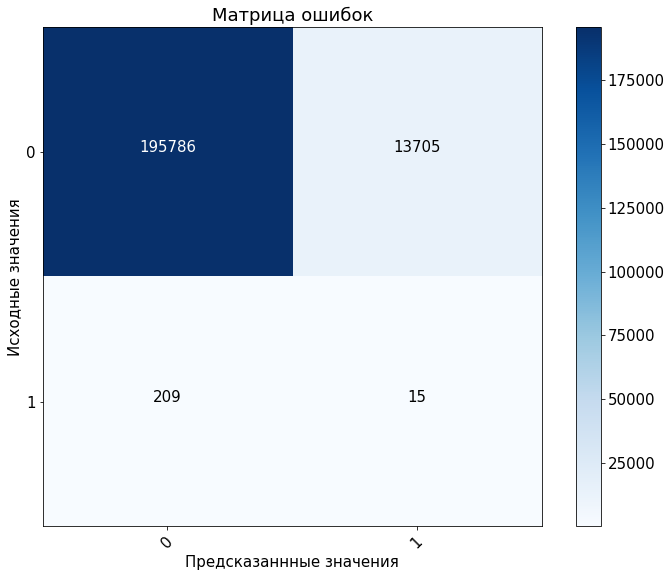

In [42]:
font = {'size' : 15}

plt.rc('font', **font)
cnf_matrix = confusion_matrix(test_label,mod.predict(test_data).astype(int))  # mod.predict(x_test)) 
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Матрица ошибок')
#plt.savefig("conf_matrix.png")
plt.show()

In [0]:
predictions_n = mod.predict(test_data)
print(metrics.accuracy_score(test_label, predictions_n))
print(metrics.recall_score(test_label, predictions_n))
print(metrics.precision_score(test_label, predictions_n))
metrics.confusion_matrix(test_label, predictions_n)

0.8286388670338316
0.15789473684210525
0.0010061205667812527


array([[173742,  35745],
       [   192,     36]])

In [0]:
#Рассчитываем F-меру для случайного леса
print(2*(metrics.precision_score(test_label, predictions)*metrics.recall_score(test_label, predictions))/(metrics.precision_score(test_label, predictions)+metrics.recall_score(test_label, predictions)))

0.8463476070528968


In [0]:
from linearmodels import PanelOLS
import statsmodels.api as sm

#year = pd.Categorical(train_data['step'])
train_a = train_data.set_index(['nameDest', 'step'])
#train_data['step'] = step

exog_vars = ['type', 'amount','nameOrig','balanceOrigErr','balanceDestErr']
exog = sm.add_constant(train_data[exog_vars])
index = pd.MultiIndex.from_frame(train_data)
mod = PanelOLS(train_label, exog,time_effects=True)
re_res = mod.fit()
print(re_res)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


ValueError: ignored

In [0]:
train_label